In [1]:
import math
import pickle

import pandas as pd
import numpy as np

from scipy.stats import beta
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
matplotlib.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [3]:
import sys
sys.path.append('..')
from data_processing.data import create_profiles, get_data, get_beta_params

In [4]:
adj_dict = pickle.load(open('pickles/ltla_adjacency_dict.pickle', 'rb'))

all_ltlas = list(adj_dict.keys()) #+ ["Hackney and City of London"]
all_ltlas.remove("Hackney")
all_ltlas.remove("City of London")

In [6]:
# =================================================================
# Get reporting proportions of LTLA at lag 2 for 14th-30th October 2020.
# =================================================================

all_reports = {}

for i, ltla in enumerate(all_ltlas):
    
    if i%25 == 0:
        print(i, ltla)
        
    df_n = get_data(
            ltla,
            area_type = "ltla",
            path = "../data/",
            report_dates = pd.date_range(start="2020-10-04", end="2020-11-15"),
        )
    df_sub = df_n[(df_n['lag']==2)&
                      (df_n['Specimen date']>="2020-10-14") & 
                      (df_n['Specimen date']<='2020-10-30') ]
    
    check = (sum(df_sub['Daily lab-confirmed cases'] > 100) > 0)
    reports = df_sub['prop_reported'].values
    
    all_reports[ltla] = [check, reports]

0 Bournemouth, Christchurch and Poole


../data_processing/data.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[clcc] = np.nan


25 Telford and Wrekin
50 County Durham
75 Chesterfield
100 Epping Forest
125 Hertsmere
150 West Lancashire
175 East Northamptonshire
200 Sedgemoor
225 Nuneaton and Bedworth
250 Rochdale
275 Wolverhampton
300 Kingston upon Thames


In [8]:
# =================================================================
# Get reports of LTLA neighbours at lag 2 for 14th-30th October 2020.
# =================================================================

all_neighbour_reports = {}

for i, ltla in enumerate(all_ltlas):
    
    check, _ = all_reports[ltla]
    
    if check:
        neighbours = set(adj_dict[ltla])
        
        neighbour_reports = []
        for neigh_ltla in neighbours:
            if neigh_ltla in all_reports:
                _, neigh_reports = all_reports[neigh_ltla]
                if len(neigh_reports) > 0:
                    neighbour_reports.append(neigh_reports)
    
        all_neighbour_reports[ltla] = neighbour_reports

In [9]:
true_props = []
neighbour_props = []

for ltla in all_reports:
    
    check, truth = all_reports[ltla]
    
    if check:
        
        all_neighbours = all_neighbour_reports[ltla]

        if len(all_neighbours) > 0 and len(truth) > 0:
            
            neighbours = np.array(all_neighbours).mean(axis=0)
            true_props.extend(truth)
            neighbour_props.extend(list(neighbours))


In [10]:
df = get_data(
        "Manchester",
        area_type="ltla",
        path="../data/",
        report_dates=pd.date_range(start="2020-10-04", end="2020-11-15"),
    )
spatial_reports = all_neighbour_reports["Manchester"]
means = np.array(spatial_reports).mean(axis=0)
variances = np.array(spatial_reports).var(axis=0)

# get confidence bands
lower = []
upper = []
for i in range(len(means)):
    m = means[i]
    v = variances[i]
    a,b = get_beta_params(m, v)
    l,p = beta(a,b).interval(0.95)
    lower.append(l)
    upper.append(p)

df_sub = df[(df['lag']==2)&(df['Specimen date']>="2020-10-14") & (df['Specimen date']<='2020-10-30')]
df_sub['neighbours'] = means
df_sub['dt'] = df_sub['Specimen date'].dt.strftime("%Y-%m-%d")

/Users/rjersakova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rjersakova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
from scipy.stats import pearsonr
r, p = pearsonr(true_props, neighbour_props)

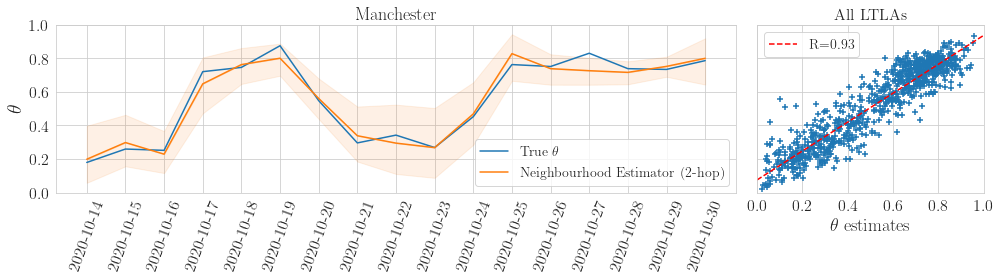

In [58]:
fig = plt.figure(figsize=(14, 4))

gs = gridspec.GridSpec(1, 2, width_ratios=[3,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

df_sub.plot('dt', 'prop_reported', ax=ax1)
df_sub.plot('dt', 'neighbours', ax=ax1)

ax1.fill_between(
    df_sub['dt'].values, means, upper, alpha=0.1, color="xkcd:orange",
)
ax1.fill_between(
    df_sub['dt'].values, means, lower, color="xkcd:orange", alpha=0.1
)

ax1.legend([r"True $\theta$", "Neighbourhood Estimator (2-hop)"], loc=4, fontsize=14)
ax1.set_title("Manchester", fontsize=18)
ax1.set_ylabel(r"$\theta$", fontsize=20)
ax1.set_xlabel("")
ax1.set_ylim(0,1)

ax1.set_xticks( np.arange(0, len(df_sub['Specimen date'])))
ax1.set_xticklabels(labels=df_sub['dt'])

ax2.scatter(true_props, neighbour_props, marker="+")
# ax2.plot(true_props, neighbour_props)
ax2.set_ylim(0,1)
ax2.axes.yaxis.set_ticklabels([])
ax2.set_xlabel(r"$\theta$ estimates", fontsize=18)
ax2.set_title("All LTLAs", fontsize=16)

slope, intercept = np.polyfit(true_props, neighbour_props, 1)
xs = np.arange(0,1.1,0.1)
ys = intercept + slope*xs
ax2.plot(xs, ys,'r--', label=f'R={r:.2f}')
ax2.legend(fontsize=14)
ax2.set_xlim(0,1)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=70)
plt.subplots_adjust(wspace=0.05)

plt.tight_layout()
plt.savefig("plots/spatial_lag_2.pdf", dpi=600)
plt.show()